In [10]:
%pip uninstall torch torch_geometric torch_scatter torch_sparse pyg_lib torch_cluster torch_spline_conv -y
# 2.1 PyTorch (CPU) – подмените индекс, если нужна CUDA
%pip install torch==2.3.0

# 2.2 PyG: с 2.3+ внешних библиотек почти нет, ставим одной строкой
%pip install torch_geometric
%pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html


# 2.4 остальное
%pip install xgboost pandas matplotlib graphviz scikit-learn tqdm numpy networkx seaborn


Found existing installation: torch 2.3.0
Uninstalling torch-2.3.0:
  Successfully uninstalled torch-2.3.0
Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.3.0-cp39-none-macosx_11_0_arm64.whl.metadata (26 kB)
Using cached torch-2.3.0-cp39-none-macosx_11_0_arm64.whl (61.0 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.3.0%2Bcpu/torch_scatter-2.1.2-cp39-cp39-macosx_10_9_universal2.whl (555 kB)
  Using cached https://data.pyg.org/whl/torch-2.3.0%2Bcpu/torch_sparse-0.6.18-cp39-cp39-macosx_11

In [34]:
from pathlib import Path
import networkx as nx
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import to_undirected
import math
import torch_cluster

print(torch.__version__)

2.3.0


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Чтение датасета

In [68]:
from pathlib import Path
ACCOUNTS_CSV = Path('./tmp/Ethereum/account.csv')      # обновите при необходимости
TXS_CSV      = Path('./tmp/Ethereum/transaction.csv')   # обновите при необходимости

assert ACCOUNTS_CSV.exists(), f'{ACCOUNTS_CSV} not found'
assert TXS_CSV.exists(), f'{TXS_CSV} not found'

In [69]:
acc_df = pd.read_csv(ACCOUNTS_CSV, header=None, names=['id', 'label'])
tx_df  = pd.read_csv(TXS_CSV, header=None, names=['src', 'dst', 'amount', 'timestamp'])

display(acc_df.head())
display(tx_df.head())

,id,label
0,0x8335392fe1b236296c5d5f653264396de165e46c,True
1,0x9d4b62503b4b7993182323effe6245f6d77e4413,True
2,0xc91293245b669da19a96cd85d40bb9c203359657,True
3,0x1056d8d9ebb0e0d8710a0e2a1852d4a09d56464a,True
4,0x4f1872383be22878af5d4795b69be61b35ec5d10,True


,src,dst,amount,timestamp
0,0x21f74c6bbc1e3ab9f0205e12de3a9daa14351aed,0x46f1c0481803cb34a7860d614b5430c5db51bfb7,5.00000,1.502740e+09
1,0x54008c2684d96c44a094dc127842ec144b157e96,0x1acee83486b6671b005eed45c9fb9277e7eeb63d,2.34758,1.518731e+09
2,0x97aeb9b292c00405e145d9c7a8429bc970fa0e65,0x4f00b95c625c6d6ef72748d78c750fd6c84a8b85,0.01003,1.516224e+09
3,0x2dfdf31bbc29468d487591f292872a14c1f8d1f0,0x474057adf42f9f955e86aa1142740f9d7763e41e,0.51587,1.522422e+09
4,0x5b39067ee0309856edd13f23c9c1793f9fda1b4f,0x6376baf58c4c5d70ba8fca9565b6955f07c584a9,6.67000,1.514817e+09


## 🏗️ Сборка графа

In [70]:
G = nx.DiGraph()

# add nodes
for _, row in acc_df.iterrows():
    G.add_node(row.id, label=int(bool(row.label)))

# add edges
for _, row in tx_df.iterrows():
    G.add_edge(row.src, row.dst, amount=float(row.amount), ts=float(row.timestamp))

print(f'Граф содержит {G.number_of_nodes():,} узлов и {G.number_of_edges():,} рёбер')

Граф содержит 32,168 узлов и 42,044 рёбер


In [71]:
# Структурные признаки
in_deg  = dict(G.in_degree())
out_deg = dict(G.out_degree())

# Финансовые суммы
sent_sum = {n: 0.0 for n in G.nodes()}
recv_sum = {n: 0.0 for n in G.nodes()}
for u, v, d in G.edges(data=True):
    amt = d['amount']
    sent_sum[u] += amt
    recv_sum[v] += amt

# PageRank и кластерный коэффициент
pr = nx.pagerank(G, alpha=0.85)
clust = nx.clustering(G.to_undirected())

# Записываем фичи в граф
for n in G.nodes():
    G.nodes[n].update({
        'in_deg':      in_deg.get(n, 0),
        'out_deg':     out_deg.get(n, 0),
        'sent_sum':    sent_sum[n],
        'recv_sum':    recv_sum[n],
        'net_sum':     sent_sum[n] - recv_sum[n],
        'pagerank':    pr[n],
        'clustering':  clust[n],
    })

# --- после расчёта pr и clust --------------------------------------------
print('⏳ Calculating extra graph features…')

# 1) Betweenness (approx)
btw = nx.betweenness_centrality(G, k=10_000, seed=42, normalized=True)

# 2) Weakly-connected component size
G_u = G.to_undirected()
wcc = {n: 0 for n in G}
for comp in nx.connected_components(G_u):
    size = len(comp)
    for n in comp:
        wcc[n] = size

# 3) Min amounts
send_min = {n: math.inf for n in G}
recv_min = {n: math.inf for n in G}
for u, v, d in G.edges(data=True):
    amt = d['amount']
    send_min[u] = min(send_min[u], amt)
    recv_min[v] = min(recv_min[v], amt)
# заменяем inf → 0.0 (узлы без операций)
send_min = {n: 0.0 if math.isinf(v) else v for n, v in send_min.items()}
recv_min = {n: 0.0 if math.isinf(v) else v for n, v in recv_min.items()}

# --- записываем все новые фичи в вершины ----------------------------------
for n in G.nodes():
    G.nodes[n].update({
        'btw_centr':   btw[n],
        'wcc_size':    wcc[n],
        'send_min':    send_min[n],
        'recv_min':    recv_min[n],
    })

⏳ Calculating extra graph features…


In [72]:
 # --- перед обучением Node2Vec: создаём маппинг id → idx -------------------
id2idx = {n: i for i, n in enumerate(G.nodes())}

# --- строим edge_index по числовым индексам ------------------------------
edges = list(G.edges())
row = [id2idx[u] for u, v in edges]
col = [id2idx[v] for u, v in edges]
edge_index = torch.tensor([row, col], dtype=torch.long)
edge_index = to_undirected(edge_index).contiguous()

# --- теперь обучаем Node2Vec на неориентированном графе --------------------
print('⏳ Training Node2Vec…')
n2v = Node2Vec(
    edge_index=edge_index,
    num_nodes=G.number_of_nodes(),
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=5,
    num_negative_samples=1,
    sparse=True,
    p=1, q=1
).to(device)

loader = n2v.loader(batch_size=1024, shuffle=True)
opt = torch.optim.SparseAdam(list(n2v.parameters()), lr=0.01)

n2v.train()
for epoch in range(25):  # можете увеличить число эпох
    total_loss = 0
    for pos_rw, neg_rw in loader:
        opt.zero_grad()
        loss = n2v.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss {total_loss:.4f}')

⏳ Training Node2Vec…
Epoch 1, Loss 245.7613
Epoch 2, Loss 185.3026
Epoch 3, Loss 150.1622
Epoch 4, Loss 122.0527
Epoch 5, Loss 99.6595
Epoch 6, Loss 82.5037
Epoch 7, Loss 69.6590
Epoch 8, Loss 59.6618
Epoch 9, Loss 52.0009
Epoch 10, Loss 46.0809
Epoch 11, Loss 41.4439
Epoch 12, Loss 37.8630
Epoch 13, Loss 35.1208
Epoch 14, Loss 33.0684
Epoch 15, Loss 31.4721
Epoch 16, Loss 30.2646
Epoch 17, Loss 29.3169
Epoch 18, Loss 28.5884
Epoch 19, Loss 28.0066
Epoch 20, Loss 27.5404
Epoch 21, Loss 27.1580
Epoch 22, Loss 26.8574
Epoch 23, Loss 26.6057
Epoch 24, Loss 26.3867
Epoch 25, Loss 26.2061
Epoch 26, Loss 26.0572
Epoch 27, Loss 25.9309
Epoch 28, Loss 25.8134
Epoch 29, Loss 25.7150
Epoch 30, Loss 25.6112
Epoch 31, Loss 25.5576
Epoch 32, Loss 25.4691
Epoch 33, Loss 25.4273
Epoch 34, Loss 25.3656
Epoch 35, Loss 25.3163
Epoch 36, Loss 25.2762
Epoch 37, Loss 25.2269
Epoch 38, Loss 25.1934
Epoch 39, Loss 25.1589
Epoch 40, Loss 25.1385


In [73]:
# --- извлекаем эмбеддинги и записываем обратно в G ------------------------
z = n2v.embedding.weight.detach().cpu()
for n, idx in id2idx.items():
    G.nodes[n]['n2v'] = z[idx]

# --- при формировании data.x ---------------------------------------------
# Наконец, собираем x
num_attr_keys = [
    'in_deg','out_deg','sent_sum','recv_sum','net_sum',
    'pagerank','clustering',
    'btw_centr','wcc_size','send_min','recv_min'
]

for n in G.nodes():
    # проверяем, что всё есть
    missing = [k for k in num_attr_keys if k not in G.nodes[n]]
    if missing:
        raise RuntimeError(f"У узла {n} нет фичей {missing}")
    base = [float(G.nodes[n][k]) for k in num_attr_keys]
    emb  = G.nodes[n]['n2v'].tolist()           # 128-мерный эмбеддинг
    G.nodes[n]['x'] = torch.tensor(base + emb, dtype=torch.float)

print('Пример фич узла:', list(G.nodes(data=True))[0])

Пример фич узла: ('0x8335392fe1b236296c5d5f653264396de165e46c', {'label': 1, 'in_deg': 4, 'out_deg': 1, 'sent_sum': 3.49954, 'recv_sum': 3.4999599999999997, 'net_sum': -0.0004199999999996429, 'pagerank': 4.475874254314406e-05, 'clustering': 0, 'btw_centr': 0.0, 'wcc_size': 30701, 'send_min': 3.49954, 'recv_min': 0.5, 'n2v': tensor([ 2.5147e-01,  1.0724e-01, -1.8274e-01, -1.6350e-01, -1.3108e-01,
         1.4439e-01,  3.9212e-01,  1.1719e-01,  4.6069e-01, -1.1697e-01,
         9.6447e-02,  5.8591e-01,  5.4330e-02,  5.8470e-01,  2.7614e-02,
        -2.9505e-01, -1.8681e-01, -3.0454e-01,  1.4393e-01, -2.8092e-01,
         1.4683e-01, -8.5641e-03, -5.6389e-01,  1.0052e-02,  1.1609e-02,
         3.9844e-01, -2.1587e-01, -4.3125e-01, -6.1352e-01, -2.4279e-01,
        -7.7257e-02,  3.2719e-01,  1.7583e-01, -1.3247e-01,  1.7802e-01,
         7.7788e-02, -6.0675e-01,  6.6237e-01, -4.4982e-01,  1.0029e-01,
         2.4202e-01,  3.1705e-01, -2.1217e-01,  3.1764e-04, -5.5723e-02,
        -2.8012e-

In [74]:
# 🔧 Делаем так, чтобы у всех узлов была метка
nx.set_node_attributes(G, -1, "label")        # сначала всем ставим -1
for _, row in acc_df.iterrows():              # затем переопределяем тем, что есть в accounts.csv
    G.nodes[row.id]["label"] = int(bool(row.label))   

In [75]:
# после формирования всех численных признаков, до отправки в PyG
from sklearn.preprocessing import StandardScaler
X = np.stack([G.nodes[n]['x'].numpy() for n in G.nodes()])
scaler = StandardScaler()
X = scaler.fit_transform(X)
for n, vec in zip(G.nodes(), X):
    G.nodes[n]['x'] = torch.tensor(vec, dtype=torch.float)

## 🔄 Конвертация в `torch_geometric.data.Data`

In [76]:
num_attr_keys = ['in_deg','out_deg','sent_sum','recv_sum','net_sum','pagerank','clustering']

for n in G.nodes():
    G.nodes[n]['x'] = torch.tensor([float(G.nodes[n][k]) for k in num_attr_keys], dtype=torch.float)

data = from_networkx(G, group_node_attrs=['x'])
data.y = torch.tensor([G.nodes[n].get('label', -1) for n in G.nodes()], dtype=torch.long)

print("Num features:", data.num_node_features)  
print(data)

Num features: 7
Data(edge_index=[2, 42044], label=[32168], in_deg=[32168], out_deg=[32168], sent_sum=[32168], recv_sum=[32168], net_sum=[32168], pagerank=[32168], clustering=[32168], btw_centr=[32168], wcc_size=[32168], send_min=[32168], recv_min=[32168], n2v=[32168, 128], amount=[42044], ts=[42044], x=[32168, 7], y=[32168])


In [77]:
import torch

# 1) Список «старых» фичей уже в data.x: shape [N,7]
X_base = data.x                # float32, device может быть CPU или CUDA

# 2) Достаём остальные скалярные фичи и приводим к форме [N,1]
btw      = data.btw_centr.view(-1,1)   # [N] → [N,1]
wcc      = data.wcc_size.view(-1,1)
send_min = data.send_min.view(-1,1)
recv_min = data.recv_min.view(-1,1)

# 3) Node2Vec: shape [N,128]
X_n2v    = data.n2v               # уже [N,128]

# 4) Конкатенируем всё в один [N, 7+4+128 = 139]
data.x = torch.cat([X_base, btw, wcc, send_min, recv_min, X_n2v], dim=1)

print("Now num features:", data.x.size(1))  # должно быть 139

Now num features: 139


In [78]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1) выгружаем data.x в NumPy
X = data.x.cpu().numpy()   # shape [N,139]

# 2) лог-трансформации неотрицательных признаков
log_idxs = [0,1,2,3,7,8,9,10]
X[:, log_idxs] = np.log1p(X[:, log_idxs])

# 3) чистим NaN/Inf → конечные числа
#    nan → 0.0, +inf → max_float32, -inf → min_float32
X = np.nan_to_num(
    X,
    nan=0.0,
    posinf=np.finfo(np.float32).max,
    neginf=np.finfo(np.float32).min
)

# (можно проверить, что теперь все конечные)
assert np.isfinite(X).all(), "Есть ещё не-конечные элементы!"

# 4) стандартизация
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 5) обратно в TorchTensor
import torch
data.x = torch.tensor(X, dtype=torch.float32).to(device)

## ✂️ Train / Val / Test сплит

In [79]:
import hashlib
import numpy as np
import torch

# 1) Собираем список узлов в порядке G.nodes()
nodes = list(G.nodes())

# 2) Хешируем каждый ID (md5 → целое), берём mod 100 → [0..99]
hash_vals = np.array([
    int(hashlib.md5(str(n).encode()).hexdigest(), 16) % 100
    for n in nodes
])

# 3) Порог: [0,59] → train, [60,79] → val, [80,99] → test
train_mask = torch.tensor(hash_vals < 60, dtype=torch.bool)
val_mask   = torch.tensor((hash_vals >= 60) & (hash_vals < 80), dtype=torch.bool)
test_mask  = torch.tensor(hash_vals >= 80, dtype=torch.bool)

# 4) Привязываем к data
data.train_mask = train_mask
data.val_mask   = val_mask
data.test_mask  = test_mask

# Проверим доли
print(f"Train: {train_mask.sum().item()/len(nodes):.2%}, "
      f"Val: {val_mask.sum().item()/len(nodes):.2%}, "
      f"Test: {test_mask.sum().item()/len(nodes):.2%}")

train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,        # корневые узлы для train
    num_neighbors=[25, 15],             # сколько соседей на каждом слое
    batch_size=1024,
    shuffle=True,
)
val_loader = NeighborLoader(
    data,
    input_nodes=data.val_mask,
    num_neighbors=[25, 15],
    batch_size=1024,
    shuffle=False,
)
test_loader = NeighborLoader(
    data,
    input_nodes=data.test_mask,
    num_neighbors=[25, 15],
    batch_size=1024,
    shuffle=False,
)

Train: 60.10%, Val: 20.03%, Test: 19.87%


In [80]:
OUT_PATH = Path('./artifacts/eth_graph.pt')
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(data, OUT_PATH)
print(f'Сериализовано в {OUT_PATH.resolve()}')

Сериализовано в /Users/a1234/Fraud/gnn/artifacts/eth_graph.pt


## 🧠 Определение GNN‑модели (GCN)

In [81]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


# 1) Определяем GraphSAGE
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_ch, hidden_ch, out_ch, dropout=0.25):
        super().__init__()
        self.conv1 = SAGEConv(in_ch, hidden_ch)
        self.conv2 = SAGEConv(hidden_ch, out_ch)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

## 🏃‍♂️ Обучение и валидация

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

labels = data.y[data.y != -1]
counts = torch.bincount(labels)
weight = torch.tensor([1.0, counts[0].float() / counts[1].float()], device=device)
print(f"Class weights: normal={weight[0]:.2f}, fraud={weight[1]:.2f}")

# 3) Инициализируем модель, optimizer, criterion (с весами из шага 2)
model = GraphSAGE(
    in_ch=data.num_node_features,
    hidden_ch=256,
    out_ch=int(data.y.max().item())+1,
    dropout=0.45
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

# 4) Цикл обучения
def train_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        # только первые batch.batch_size предсказаний — для корневых узлов
        loss = criterion(out[:batch.batch_size], batch.y[:batch.batch_size])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.batch_size
    return total_loss / int(data.train_mask.sum())

@torch.no_grad()
def eval_loader(loader):
    model.eval()
    correct = total = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        logits = out[:batch.batch_size]
        y = batch.y[:batch.batch_size]

        # Только размеченные
        mask = (y != -1)
        if mask.sum() == 0:
            continue

        preds = logits.argmax(dim=1)
        correct += int((preds[mask] == y[mask]).sum())
        total   += int(mask.sum())

    return correct / total if total > 0 else 0.0

num_epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs     = [], []

# Функция для вычисления средней потери на валидации
@torch.no_grad()
def eval_loss(loader):
    model.eval()
    total_loss, total = 0.0, 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        logits = out[:batch.batch_size]
        y = batch.y[:batch.batch_size]
        mask = (y != -1)
        if mask.sum() == 0:
            continue
        loss = criterion(logits[mask], y[mask])
        total_loss += loss.item() * mask.sum().item()
        total += mask.sum().item()
    return total_loss / total if total > 0 else 0.0

# Перезапускаем цикл обучения с сохранением метрик
for epoch in range(1, num_epochs + 1):
    loss = train_epoch()
    train_acc = eval_loader(train_loader)
    val_loss  = eval_loss(val_loader)
    val_acc   = eval_loader(val_loader)

    train_losses.append(loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f'Epoch {epoch:02d} | Train Loss {loss:.4f} | Val Loss {val_loss:.4f} '
          f'| Train Acc {train_acc:.3f} | Val Acc {val_acc:.3f}')


test_acc = eval_loader(test_loader)
print(f'✅ Test Accuracy: {test_acc:.3f}')

Class weights: normal=1.00, fraud=1.72
Epoch 01 | Train Loss 0.5656 | Val Loss 0.2816 | Train Acc 0.947 | Val Acc 0.908
Epoch 02 | Train Loss 0.2542 | Val Loss 0.2811 | Train Acc 0.976 | Val Acc 0.935
Epoch 03 | Train Loss 0.2129 | Val Loss 0.3633 | Train Acc 0.968 | Val Acc 0.917
Epoch 04 | Train Loss 0.2144 | Val Loss 0.3018 | Train Acc 0.975 | Val Acc 0.926
Epoch 05 | Train Loss 0.2316 | Val Loss 0.4161 | Train Acc 0.977 | Val Acc 0.932
Epoch 06 | Train Loss 0.1729 | Val Loss 0.4149 | Train Acc 0.979 | Val Acc 0.917
Epoch 07 | Train Loss 0.1652 | Val Loss 0.4227 | Train Acc 0.986 | Val Acc 0.942
Epoch 08 | Train Loss 0.1854 | Val Loss 0.5372 | Train Acc 0.982 | Val Acc 0.938
Epoch 09 | Train Loss 0.2131 | Val Loss 0.5478 | Train Acc 0.989 | Val Acc 0.939
Epoch 10 | Train Loss 0.2193 | Val Loss 0.6155 | Train Acc 0.990 | Val Acc 0.932
Epoch 11 | Train Loss 0.1998 | Val Loss 0.6458 | Train Acc 0.987 | Val Acc 0.929
Epoch 12 | Train Loss 0.2640 | Val Loss 0.6904 | Train Acc 0.984 | Val

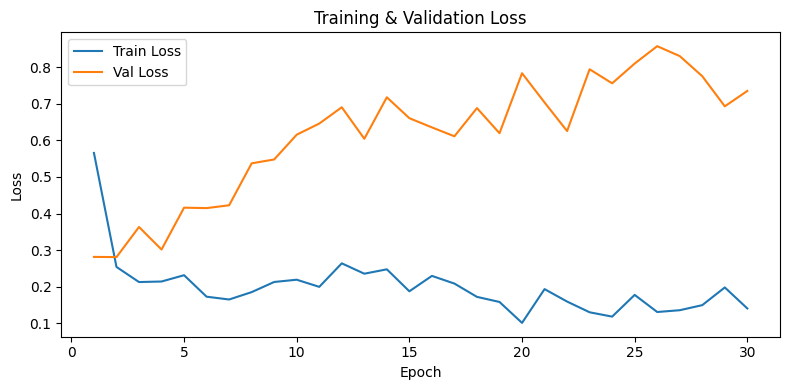

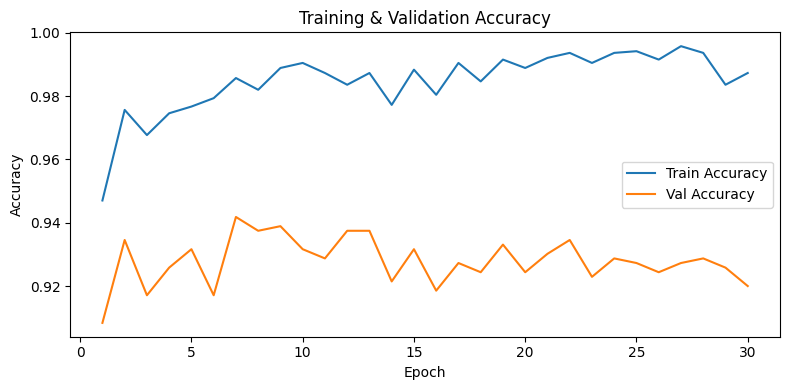

In [103]:
# ─── Визуализация кривых обучения ───────────────────────────────────────────────
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(8,4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs,   label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## 📊 Визуализация результатов
Вычислим метрики на тестовой выборке и отобразим матрицу ошибок.

              precision    recall  f1-score   support

           0      0.957     0.905     0.930       369
           1      0.853     0.931     0.890       218

    accuracy                          0.915       587
   macro avg      0.905     0.918     0.910       587
weighted avg      0.918     0.915     0.916       587



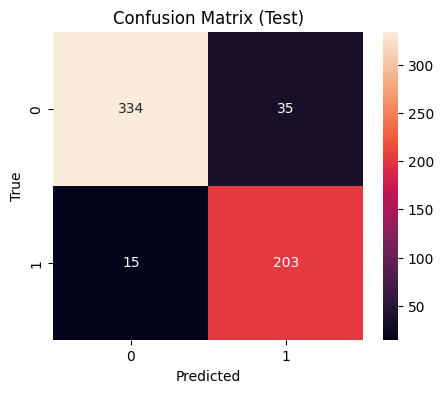

In [104]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []
for batch in test_loader:
    batch = batch.to(device)
    out = model(batch.x, batch.edge_index)
    logits = out[:batch.batch_size]
    y = batch.y[:batch.batch_size]
    mask = (y != -1)

    all_preds.append(logits.argmax(dim=1)[mask].cpu())
    all_labels.append(y[mask].cpu())

y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()
print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 🕵️‍♂️ Интерпретация предсказаний с **GNNExplainer**
Выберем произвольный корректно классифицированный узел из тестовой выборки и посмотрим, какие рёбра и признаки были наиболее важны для модели.

In [ ]:
# %% 
# ## 🕵️‍♂️ Интерпретация предсказаний с GNNExplainer (inline, с именами фичей)

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer, GNNExplainer

# 1) Найти первый корректно классифицированный узел
model.eval()
target_node = None
for batch in test_loader:
    batch = batch.to(device)
    out   = model(batch.x, batch.edge_index)
    preds = out[:batch.batch_size].argmax(dim=1)
    y     = batch.y[:batch.batch_size]
    mask  = (y != -1) & (preds == y)
    if mask.any():
        idx_local   = mask.nonzero(as_tuple=True)[0][0].item()
        target_node = batch.n_id[idx_local].item()
        break

print(f'🔍 Объясняем решение для узла {target_node}')

# 2) Подготовить Explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
)

# 3) Сгенерировать Explanation
explanation = explainer(
    x=data.x, 
    edge_index=data.edge_index, 
    index=target_node,
)

# 4) Бар-граф топ-10 фич с человеческими названиями
feat_names = [
    'in_deg','out_deg','sent_sum','recv_sum','net_sum',
    'pagerank','clustering',
    'btw_centr','wcc_size','send_min','recv_min'
] + [f'n2v_{i}' for i in range(128)]

feat_imp = explanation.node_mask.cpu().numpy()
top_k    = 10
idxs     = np.argsort(feat_imp)[-top_k:][::-1]
idxs     = [int(i) for i in idxs]      # <<< вот фикс
vals     = feat_imp[idxs]
names    = [feat_names[i] for i in idxs]

plt.figure(figsize=(8,4))
plt.barh(names, vals)
plt.xlabel('Importance')
plt.title(f'Top {top_k} Feature Importances for node {target_node}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 5) Визуализация объясняющего субграфа inline через NetworkX
edge_mask = explanation.edge_mask.cpu().numpy()
E, F = data.edge_index.cpu().numpy(), edge_mask
k = 20
top_e = np.argsort(F)[-k:]
mask = np.zeros_like(F, dtype=bool)
mask[top_e] = True
sub_edges = E[:, mask].T.tolist()

G_sub = nx.Graph()
G_sub.add_edges_from(sub_edges)
pos = nx.spring_layout(G_sub, seed=42)

colors = ['red' if n == target_node else 'lightblue' for n in G_sub.nodes()]

plt.figure(figsize=(6,6))
nx.draw(
    G_sub, pos,
    node_size=100,
    node_color=colors,
    with_labels=False
)
plt.title(f'Explanation Subgraph for node {target_node}')
plt.show()

🔍 Объясняем решение для узла 0


## 💾 Сохранение обученной модели

In [105]:
MODEL_PATH = Path('./checkpoints/gcn_model.pt')
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), MODEL_PATH)
print(f'Модель сохранена в {MODEL_PATH.resolve()}')

Модель сохранена в /Users/a1234/Fraud/gnn/checkpoints/gcn_model.pt
